In [20]:
##进行xgboost的训练
import warnings
warnings.filterwarnings('ignore')

import gc
import csv
import time 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.externals import joblib

In [2]:
file_train = './out_put/encode_data_train.csv'
file_vali = './out_put/encode_data_vali.csv'
file_test = './out_put/encode_data_test.csv'

df_train = pd.read_csv(file_train, index_col = 0)
df_vali = pd.read_csv(file_vali, index_col = 0)
df_test = pd.read_csv(file_test, index_col = 0)

In [3]:
##数据准备
y_train = df_train['click']
x_train = df_train.iloc[:,1:]

y_vali = df_vali['click']
x_vali = df_vali.iloc[:,1:]

y_test = df_test['click']
x_test = df_test.iloc[:,1:]

In [4]:
##进行xgboost拟合
begin_time = time.time()
print(f'Begin Time : {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(begin_time))}')

##受限于机器的资源，这里就不做gridsearch调参了，直接凑合着来(按最小资源消耗来设置参数)
model = XGBClassifier(learning_rate=0.1
                     ,n_estimators=10
                     ,max_depth=3
                     ,scale_pos_weight=1
                     ,min_child_weight=1
                     ,gamma=0
                     ,subsample=1
                     ,colsample_bylevel=1
                     ,objective='binary:logistic'
                     ,n_jobs=4
                     ,seed=100)

eval_set = [(x_vali, y_vali)]
model.fit(x_train, y_train, eval_metric="auc" , eval_set=eval_set, early_stopping_rounds=10)

end_time = time.time()
print(f'End Time : {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))}')

Begin Time : 2020-02-01 21:19:03
[0]	validation_0-auc:0.663951
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.669895
[2]	validation_0-auc:0.670909
[3]	validation_0-auc:0.671622
[4]	validation_0-auc:0.673234
[5]	validation_0-auc:0.675165
[6]	validation_0-auc:0.675224
[7]	validation_0-auc:0.682689
[8]	validation_0-auc:0.684437
[9]	validation_0-auc:0.687103
End Time : 2020-02-01 21:19:09


In [5]:
##保存xgb的model
joblib.dump(model, './model/xgb_model.pkl')

['./model/xgb_model.pkl']

In [6]:
#我们来拿到xgb的叶子节点的特征
##进行xgboost拟合
begin_time = time.time()
print(f'Begin Time : {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(begin_time))}')

##apply函数返回的是叶子索引
x_train_leaves = model.apply(x_train).astype(np.int32)
x_test_leaves = model.apply(x_test).astype(np.int32)

#使用nunpy的concatenate来拼接数组，并生成全局的onehot，单一使用train的可能会漏掉编码，test验证的时候出问题
x_leaves = np.concatenate((x_train_leaves,x_test_leaves), axis=0)

print(f'Transform xgb leaves shape: {x_leaves.shape}')

xgb_onehotcoder = OneHotEncoder()
xgb_onehotcoder.fit(x_leaves)

x_train_lr = xgb_onehotcoder.transform(x_train_leaves).toarray()
x_test_lr = xgb_onehotcoder.transform(x_test_leaves).toarray()
print(f'Transform xgb x_train_lr shape: {x_train_lr.shape}')
print(f'Transform xgb x_test_lr shape: {x_test_lr.shape}')

end_time = time.time()
print(f'End Time : {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))}')

Begin Time : 2020-02-01 21:19:13
Transform xgb leaves shape: (859999, 10)
Transform xgb x_train_lr shape: (559999, 80)
Transform xgb x_test_lr shape: (300000, 80)
End Time : 2020-02-01 21:19:15


In [7]:
# ##机器资源较小，进行部分变量内存回收
# del df_train,df_vali,df_test,model,x_vali,x_train_leaves,x_test_leaves,x_leaves,xgb_onehotcoder
# gc.collect()

In [8]:
# np_train_lr = np.hstack((np.array(np.mat(y_train).transpose()),x_train_lr))
# np.savetxt("./out_put/encode_data_train_lr.csv", np_train_lr, delimiter=',')

In [9]:
# del np_train_lr
# gc.collect()

In [10]:
# np_test_lr = np.hstack((np.array(np.mat(y_test).transpose()),x_test_lr))
# np.savetxt("./out_put/encode_data_test_lr.csv", np_test_lr, delimiter=',')

In [11]:
# del np_test_lr
# gc.collect()

In [12]:
##进行one特征与原始特征的拼接
x_train_lr2 = np.hstack((x_train_lr, x_train.values))
print(f'Transform xgb x_train_lr2 shape: {x_train_lr2.shape}')

# np_train_lr2 = np.hstack((np.array(np.mat(y_train).transpose()),x_train_lr2))
# np.savetxt("./out_put/encode_data_train_lr2.csv", np_train_lr2, delimiter=',')

Transform xgb x_train_lr2 shape: (559999, 101)


In [13]:
# del x_train,x_train_lr,x_train_lr2,np_train_lr2
# gc.collect()

In [14]:
x_test_lr2 = np.hstack((x_test_lr, x_test.values))
print(f'Transform xgb x_test_lr2 shape: {x_test_lr2.shape}')

# np_test_lr2 = np.hstack((np.array(np.mat(y_test).transpose()),x_test_lr2))
# np.savetxt("./out_put/encode_data_test_lr2.csv", np_test_lr2, delimiter=',')

Transform xgb x_test_lr2 shape: (300000, 101)


In [15]:
##回收部分资源，资源不够了
del df_train,df_vali,df_test,x_vali,x_train_leaves,x_test_leaves,x_leaves,xgb_onehotcoder
gc.collect()

84

In [16]:
###灌入到LR中
begin_time = time.time()
print(f'Begin Time : {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(begin_time))}')

lr_model = LogisticRegression()
lr_model.fit(x_train_lr, y_train)

lr_model2 = LogisticRegression()
lr_model2.fit(x_train_lr2, y_train)

joblib.dump(lr_model, './model/lr_model.pkl')
joblib.dump(lr_model2, './model/lr_model2.pkl')

end_time = time.time()
print(f'End Time : {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))}')

Begin Time : 2020-02-01 21:19:55
End Time : 2020-02-01 21:20:19


In [23]:
##效果输出函数
def func_print_score(x_data,y_data,data_type,model_x):
    y_pred = model_x.predict(x_data)
    
    print(f'==============({data_type})===================')
    confusion = metrics.confusion_matrix(y_data, y_pred)
    print(confusion)
    
    print('------------------------')
    auc = metrics.roc_auc_score(y_data,y_pred)
    print(f'AUC: {auc}')
    
    print('------------------------')
    accuracy = metrics.accuracy_score(y_data,y_pred)
    print(f'Accuracy: {accuracy}')
    
    print('------------------------')
    aupr = metrics.average_precision_score(y_data, y_pred)
    print(f'AUPR: {aupr}')
    
    print('------------------------')
    report = metrics.classification_report(y_data, y_pred)
    print(report) 
    
    print('=============================================')

In [24]:
func_print_score(x_test,y_test,'testdata-xgb', model)
func_print_score(x_test_lr,y_test,'testdata-xgb-lr', lr_model)
func_print_score(x_test_lr2,y_test,'testdata-xgb-lr2', lr_model2)

==============(testdata-xgb)===================
[[248629   3305]
 [ 44416   3650]]
------------------------
AUC: 0.5314093688885991
------------------------
Accuracy: 0.84093
------------------------
AUPR: 0.18790537837217178
------------------------
             precision    recall  f1-score   support

          0       0.85      0.99      0.91    251934
          1       0.52      0.08      0.13     48066

avg / total       0.80      0.84      0.79    300000

==============(testdata-xgb-lr)===================
[[247447   4487]
 [ 43073   4993]]
------------------------
AUC: 0.5430338904724129
------------------------
Accuracy: 0.8414666666666667
------------------------
AUPR: 0.19828793875544898
------------------------
             precision    recall  f1-score   support

          0       0.85      0.98      0.91    251934
          1       0.53      0.10      0.17     48066

avg / total       0.80      0.84      0.79    300000

==============(testdata-xgb-lr2)===================
[[

In [25]:
del x_train,y_train,x_train_lr,x_train_lr2
gc.collect()

7392

In [26]:
##测试数据的PR曲线
probas_xgb = model.predict_proba(x_test)
probas_lr = lr_model.predict_proba(x_test_lr)
probas_lr2 = lr_model2.predict_proba(x_test_lr2)

In [27]:
##precision_recall_curve函数
precision_xgb,recall_xgb, thresholds_xgb = metrics.precision_recall_curve(y_test, probas_xgb[:,1])
precision_lr,recall_lr, thresholds_lr = metrics.precision_recall_curve(y_test, probas_lr[:,1])
precision_lr2,recall_lr2, thresholds_lr2 = metrics.precision_recall_curve(y_test, probas_lr2[:,1])

Text(0.5,1,'PR Curve')

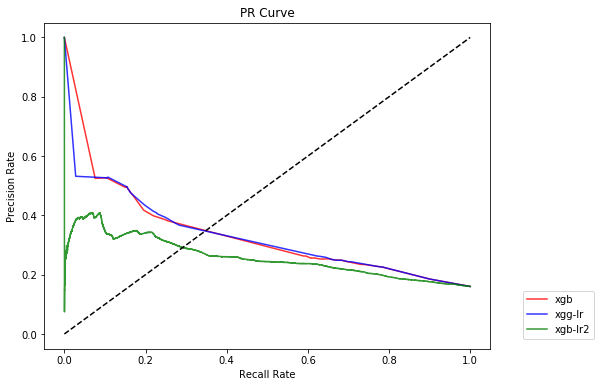

In [29]:
plt.figure(figsize=(8,6))

plt.plot(recall_xgb, precision_xgb, label = 'xgb', alpha = 0.8, color = 'red')
plt.plot(recall_lr, precision_lr, label = 'xgg-lr', alpha = 0.8, color = 'blue')
plt.plot(recall_lr2, precision_lr2, label = 'xgb-lr2', alpha = 0.8, color = 'green')

plt.plot([0,1],[0,1],'k--')

#图例打印
plt.legend(bbox_to_anchor=(1.05, 0), loc = 3, borderaxespad = 1)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Recall Rate')
plt.ylabel('Precision Rate')
plt.title('PR Curve')